# Устанавливаем необходимые пакеты

In [10]:
%pip install datasets
%pip install fasttext
%pip install --upgrade awscli
%pip install --upgrade boto3
%pip install --upgrade git+https://github.com/dask/s3fs

Defaulting to user installation because normal site-packages is not writeable
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
  Obtaining dependency information for awscli from https://files.pythonhosted.org/packages/6a/ae/51115587339c89db62f416e2319fb0c1eaff24f9c2a5a448280a733032d7/awscli-1.31.11-py3-none-any.whl.metadata
  Obtaining dependency information for botocore==1.33.11 from https://files.pythonhosted.org/packages/62/c1/d34344cffdf2dd37b4a4173ed93e38d907683a8b3fb04a61bae6539a4466/botocore-1.33.11-py3-none-any.whl.

In [36]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
import fasttext
import fasttext.util
from tqdm import trange
import torch
from torch.utils.data import DataLoader

# Скачиваем датасет

In [73]:
dataset = load_dataset("graviada/russian-ner-runne")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2508 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/512 [00:00<?, ? examples/s]

Generating dev split:   0%|          | 0/536 [00:00<?, ? examples/s]

Датасет состоит из множества предложений. Каждому слову в предложении сопоставлен класс, которому это слово принадлежит.

Задача - научиться классифицировать тип слова.

In [74]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 2508
    })
    test: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 512
    })
    dev: Dataset({
        features: ['tokens', 'tags'],
        num_rows: 536
    })
})

# Использование fasttext

Будем обучать fasttext, а не использовать предобученный, так как обученная модель весит очень много

In [14]:
with open('train_text.txt', 'w') as f:
  text = ''.join([x for x in [' '.join(a) for a in dataset['train']['tokens']]])
  f.write(text)

In [21]:
model_fasttext = fasttext.train_unsupervised("train_text.txt", epoch=15, minn=2, maxn=7, dim=100)

Read 0M words
Number of words:  2656
Number of labels: 0
Progress: 100.0% words/sec/thread:   30252 lr:  0.000000 avg.loss:  2.113559 ETA:   0h 0m 0s


In [16]:
XTrain = []
yTrain = []
for textIndex in trange(len(dataset['train']['tokens'])):
  for wordIndex in range(len(dataset['train']['tokens'][textIndex])):
    XTrain.append(model_fasttext[dataset['train']['tokens'][textIndex][wordIndex]])
    yTrain.append(dataset['train']['tags'][textIndex][wordIndex])

100%|██████████| 2508/2508 [2:28:40<00:00,  3.56s/it]


In [22]:
XTest = []
yTest = []
for textIndex in trange(len(dataset['test']['tokens'])):
  for wordIndex in range(len(dataset['test']['tokens'][textIndex])):
    XTest.append(model_fasttext[dataset['test']['tokens'][textIndex][wordIndex]])
    yTest.append(dataset['test']['tags'][textIndex][wordIndex])

100%|██████████| 512/512 [06:08<00:00,  1.39it/s]


Посмотрим на сбаллансированность и видим, что она отсутствует. Объектов первых классов гораздо большем, чем остальных

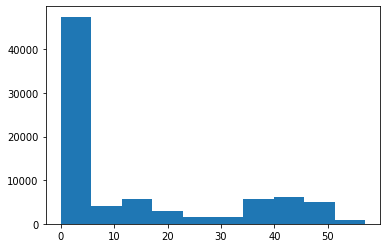

In [80]:
plt.hist(yTrain)
plt.show()

# Использование ML модели

In [78]:
models = [RandomForestClassifier(n) for n in [1, 5, 10, 50, 100, 200]]

In [82]:
scores = []
for model in models:
    print(model)
    model.fit(XTrain, yTrain)
    scores.append(model.score(XTest, yTest))
scores

RandomForestClassifier(n_estimators=1)
RandomForestClassifier(n_estimators=5)
RandomForestClassifier(n_estimators=10)
RandomForestClassifier(n_estimators=50)
RandomForestClassifier()
RandomForestClassifier(n_estimators=200)


[0.2905263157894737,
 0.5290469416785206,
 0.5589758179231863,
 0.576330014224751,
 0.5732005689900427,
 0.5738264580369844]

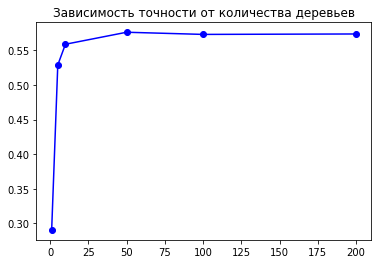

In [84]:
plt.plot([1, 5, 10, 50, 100, 200], scores, 'b-o')
plt.title("Зависимость точности от количества деревьев")
plt.show()

Можно заметить, что даже 50 деревьев достаточно для немлохой классификации и дальнейшее увеличение параметра не дает прироста в точности.

# Обучение нейронной сети

In [51]:
def get_accuracy(data_loader, model):
    tp = 0
    n = 0
    with torch.no_grad():
        for images, labels in data_loader:
            labels = labels.to(device)
            images = images.to(device)
            outputs = model(images.reshape(images.shape[0], images.shape[1], -1))
            _, predicted = torch.max(outputs.data, 1)
            n += labels.size(0)
            tp += (predicted == labels).sum()
    return tp / n

Описание модели:

In [86]:
model = torch.nn.Sequential(
    torch.nn.Conv1d(100, 512, kernel_size=3, padding=1, stride=2),
    torch.nn.BatchNorm1d(512),
    torch.nn.ReLU(),

    torch.nn.Conv1d(512, 1024, kernel_size=3, padding=1, stride=2),
    torch.nn.BatchNorm1d(1024),
    torch.nn.ReLU(),

    torch.nn.Conv1d(1024, 1024, kernel_size=3, padding=1, stride=2),
    torch.nn.BatchNorm1d(1024),
    torch.nn.ReLU(),
    
    torch.nn.Conv1d(1024, 256, kernel_size=3, padding=1, stride=2),
    torch.nn.BatchNorm1d(256),
    torch.nn.ReLU(),

    torch.nn.AdaptiveMaxPool1d(1),
    torch.nn.Flatten(),
    torch.nn.Linear(256, 58),
)

learning_rate = 0.01
num_epochs = 20

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [38]:
train_loader = DataLoader([(XTrain[i], yTrain[i]) for i in range(len(XTrain))], shuffle=True, batch_size=50)
test_loader = DataLoader([(XTest[i], yTest[i]) for i in range(len(XTest))], shuffle=False, batch_size=50)

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Процесс обучения:

In [87]:
trainScores = []
testScores = []

num_epochs = 10
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = model(images.reshape(images.shape[0], images.shape[1], -1))
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()
    
    trainScores.append(get_accuracy(train_loader, model))
    testScores.append(get_accuracy(test_loader, model))
    
    print(f'Epoch {epoch}')
    print(f'    accuracy on train data : {trainScores[-1]}')
    print(f'    accuracy on test data : {testScores[-1]}')

Epoch 0
    accuracy on train data : 0.6933220028877258
    accuracy on test data : 0.5852631330490112
Epoch 1
    accuracy on train data : 0.7130205035209656
    accuracy on test data : 0.5866287350654602
Epoch 2
    accuracy on train data : 0.7297093868255615
    accuracy on test data : 0.5991464853286743
Epoch 3
    accuracy on train data : 0.736567497253418
    accuracy on test data : 0.5974395275115967
Epoch 4
    accuracy on train data : 0.7391207814216614
    accuracy on test data : 0.5878804922103882
Epoch 5
    accuracy on train data : 0.752898633480072
    accuracy on test data : 0.60068279504776
Epoch 6
    accuracy on train data : 0.7537251114845276
    accuracy on test data : 0.5959601998329163
Epoch 7
    accuracy on train data : 0.7590537071228027
    accuracy on test data : 0.5879374146461487
Epoch 8
    accuracy on train data : 0.7607435584068298
    accuracy on test data : 0.5834993124008179
Epoch 9
    accuracy on train data : 0.7641109228134155
    accuracy on test 

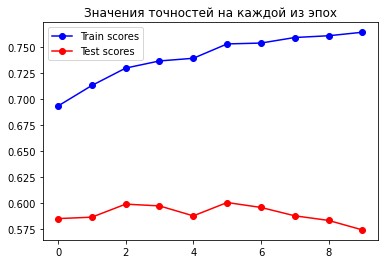

In [90]:
plt.plot([i for i in range(num_epochs)], trainScores, 'b-o', label="Train scores")
plt.plot([i for i in range(num_epochs)], testScores, 'r-o', label="Test scores")
plt.title("Значения точностей на каждой из эпох")
plt.legend()
plt.show()

# Выводы

В результате можно сделать следующие выводы:
- Классификация возможна с неплохой точностью
- Случайный лес при любых значениях параметра показал точность хуже, чем CNN